In [1]:
import torch
from diffusers import StableDiffusionPipeline

In [2]:
from diffusers import DDIMScheduler

scheduler = DDIMScheduler(beta_start=0.00085,
                          beta_end=0.012,
                          beta_schedule="scaled_linear",
                          clip_sample=False,
                          set_alpha_to_one=False)

In [3]:
pipe = StableDiffusionPipeline.from_pretrained(
    "/home/bangbang/.cache/huggingface/hub/models--Crosstyan--BPModel/snapshots/dea2172f2fa1858444b14cc948c8cf0146592604/",
    torch_dtype=torch.float16, scheduler=scheduler)
pipe = pipe.to("cuda")

/home/bangbang/StableDiffusion/diffusers/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:100: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.13.0.dev0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request for the `scheduler/scheduler_config.json` file
  deprecate("steps_offset!=1", "1.0.0", deprecation_message, standard_warn=False)


In [4]:
pipe.scheduler

DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.13.0.dev0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "steps_offset": 1,
  "trained_betas": null
}

In [5]:
prompt = "anime girl by fkey by fkey with beautiful eyes and brown hair, half-body, ink, oil painting, solo, 1girl, outdoors, 4K wallpaper"
negative_prompt = "worst quality, low quality, medium quality, deleted, lowres, comic, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, jpeg artifacts, signature, watermark, username, blurry"
output = pipe(prompt, negative_prompt=negative_prompt)
# pipe.enable_attention_slicing()
# image = pipe(prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

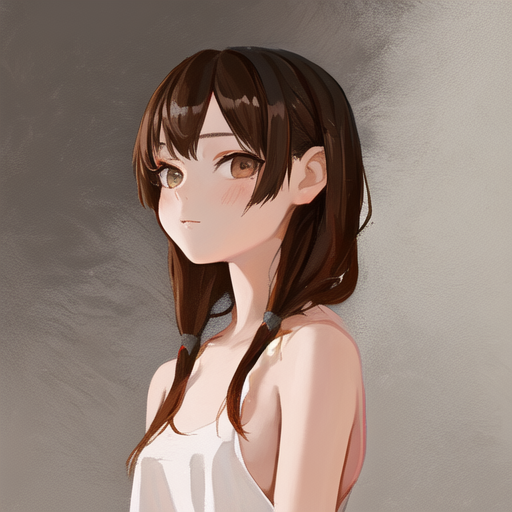

In [6]:
output[0].images[0]

In [20]:
len(output[1])

50

In [59]:
import numpy as np

In [141]:
image_test = output[1][-1].cpu().permute(0, 2, 3, 1).numpy()

In [142]:
image_test.max()

3.3121345

In [143]:
image_test.min()

-3.9313245

In [144]:
pipe.vae.config.scaling_factor

0.18215

In [145]:
image_test_01 = (image_test+2)/4

In [146]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


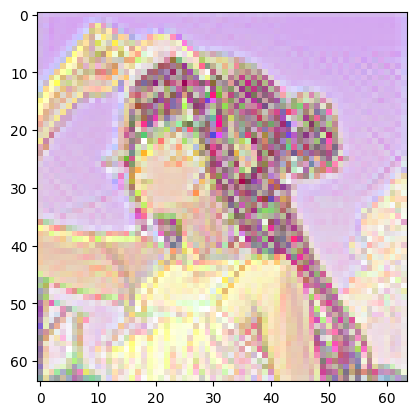

In [147]:
plt.imshow(image_test_01[0])

In [148]:
with torch.no_grad():
    vae_out = pipe.decode_latents(output[1][-30])

In [149]:
output[1][-1].shape

torch.Size([1, 4, 64, 64])

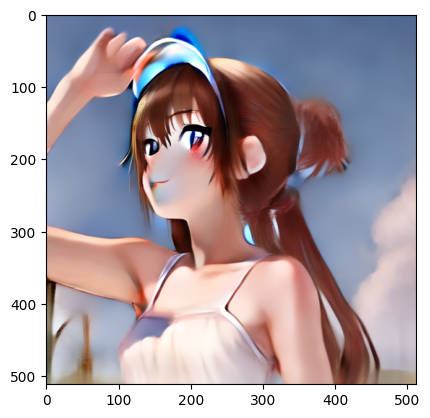

In [150]:
plt.imshow(vae_out[0])

In [151]:
vae_out.shape

(1, 512, 512, 3)

In [152]:
output_image = output[0].images[0]

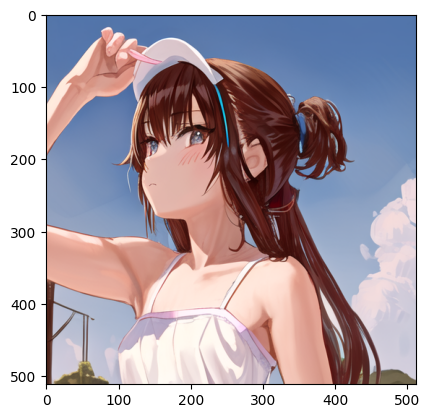

In [153]:
plt.imshow(output_image)

In [154]:
torch_image = torch.from_numpy((np.array(output_image).astype(np.float32)/255.0)[None].transpose(0, 3, 1, 2))
torch_image = 2*torch_image - 1

In [155]:
torch_image.shape

torch.Size([1, 3, 512, 512])

In [156]:
latent_dist = pipe.vae.encode(torch_image.cuda()).latent_dist

In [157]:
sampled_latent = latent_dist.sample() * 0.1825

In [158]:
sampled_latent.min()

tensor(-3.7374, device='cuda:0', grad_fn=<MinBackward1>)

In [159]:
with torch.no_grad():
    vae_out2 = pipe.decode_latents(sampled_latent)

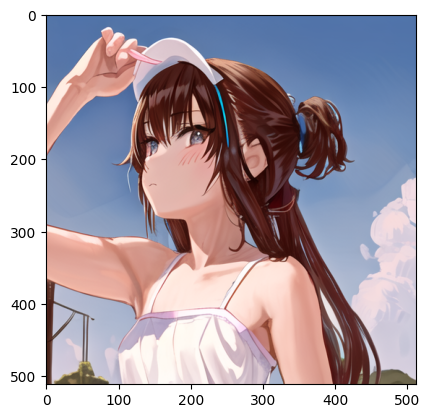

In [160]:
plt.imshow(vae_out2[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


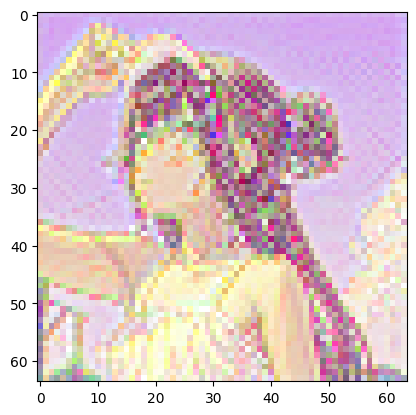

In [162]:
image_test2 = sampled_latent.cpu().detach().permute(0, 2, 3, 1).numpy()
plt.imshow((image_test2[0]+2)/4)

In [163]:
import pywt


In [175]:
image_test2.shape

(1, 64, 64, 4)

In [192]:
coeffs2 = pywt.dwt2(image_test2[0,:,:,0], 'db2')

In [193]:
LL, (LH, HL, HH) = coeffs2


In [194]:
LL.shape

(33, 33)

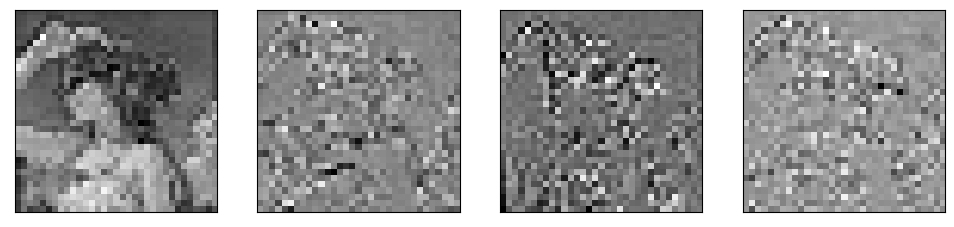

In [195]:
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_xticks([])
    ax.set_yticks([])

In [196]:
from pytorch_wavelets import DTCWTForward, DTCWTInverse

In [207]:
xfm = DTCWTForward(J=1, biort='near_sym_b', qshift='qshift_b').cuda()
Yl, Yh = xfm(sampled_latent)
ifm = DTCWTInverse(biort='near_sym_b', qshift='qshift_b').cuda()
Y = ifm((Yl, Yh))

In [208]:
Yl.shape

torch.Size([1, 4, 64, 64])

In [209]:
Yh[0].shape

torch.Size([1, 4, 6, 32, 32, 2])

In [210]:
with torch.no_grad():
    vae_out3 = pipe.decode_latents(Yl)

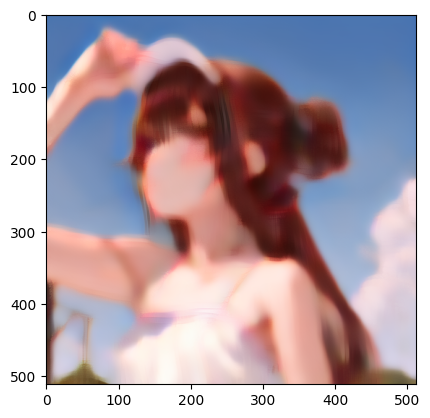

In [211]:
plt.imshow(vae_out3[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


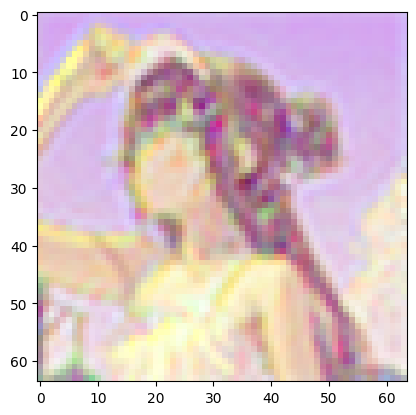

In [212]:
image_test3 = Yl.cpu().detach().permute(0, 2, 3, 1).numpy()
plt.imshow((image_test3[0]+2)/4)

In [22]:
from diffusers import StableDiffusionImg2ImgPipeline

In [23]:
pipei2i = StableDiffusionImg2ImgPipeline.from_pretrained(
    "/home/bangbang/.cache/huggingface/hub/models--Crosstyan--BPModel/snapshots/dea2172f2fa1858444b14cc948c8cf0146592604/",
    scheduler=scheduler)
pipei2i = pipei2i.to("cuda")

In [115]:
# response = requests.get(url)
# init_image = Image.open(BytesIO(response.content)).convert("RGB")
# init_image = init_image.resize((768, 512))

init_image = output[0].images[0]

prompt = "anime girl by momoko, solo, 1girl, cowboy shot, outdoors, 4K wallpaper"
negative_prompt = "fkey, worst quality, low quality, medium quality, deleted, lowres, comic, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, jpeg artifacts, signature, watermark, username, blurry"

outputi2i = pipei2i(prompt=prompt, negative_prompt=negative_prompt,
                    image=init_image, strength=0.5, guidance_scale=9.5)

  0%|          | 0/25 [00:00<?, ?it/s]

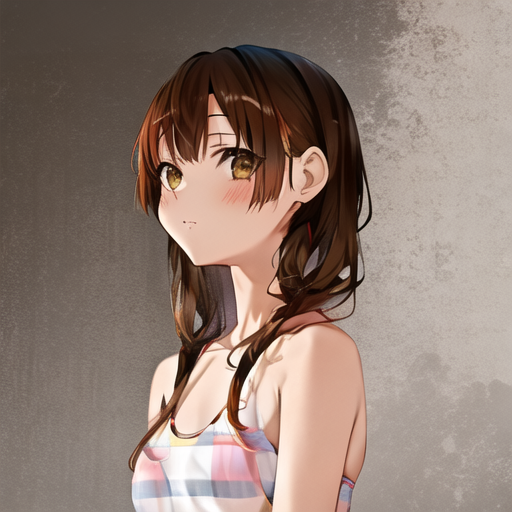

In [116]:
outputi2i.images[0]

In [7]:
from diffusers import StableDiffusionPosteriorPipeline

In [8]:
pipepos = StableDiffusionPosteriorPipeline.from_pretrained(
    "/home/bangbang/.cache/huggingface/hub/models--Crosstyan--BPModel/snapshots/dea2172f2fa1858444b14cc948c8cf0146592604/",
    scheduler=scheduler)  #, torch_dtype=torch.float16)
pipepos = pipepos.to("cuda")

In [117]:
init_image = output[0].images[0]

prompt = "anime girl by momoko, solo, 1girl, cowboy shot, outdoors, 4K wallpaper"
negative_prompt = "fkey, worst quality, low quality, medium quality, deleted, lowres, comic, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, jpeg artifacts, signature, watermark, username, blurry"

outputpos = pipepos(prompt=prompt, negative_prompt=negative_prompt,
                    image=init_image, strength=0.75, guidance_scale=9.5,
                    add_predicted_noise=False, wavelet_level=5)

  0%|          | 0/37 [00:00<?, ?it/s]

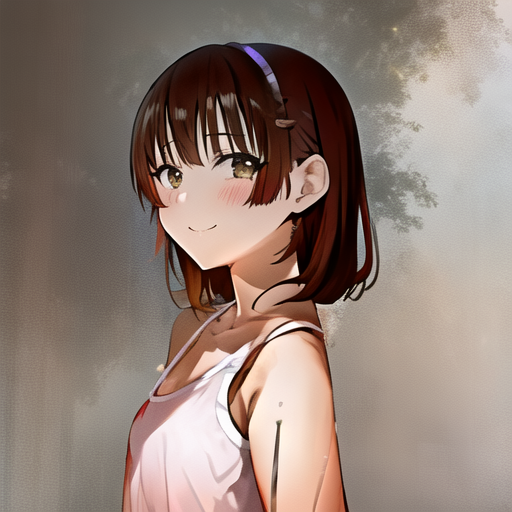

In [118]:
outputpos.images[0]

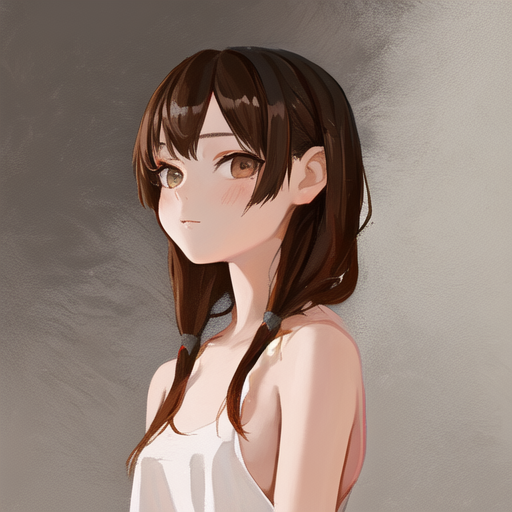

In [11]:
output[0].images[0]

In [83]:
# init_image = output[0].images[0]

prompt = "anime girl with green eyes and black hair by momoko, solo, 1girl, cowboy shot, outdoors, 4K wallpaper"
negative_prompt = "worst quality, low quality, medium quality, deleted, lowres, comic, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, jpeg artifacts, signature, watermark, username, blurry"

outputpos = pipepos(prompt=prompt, negative_prompt=negative_prompt,
                    image=init_image, strength=0.9, guidance_scale=8,
                    add_predicted_noise=True, wavelet_level=2, match_high_frequency=True)

  0%|          | 0/45 [00:00<?, ?it/s]

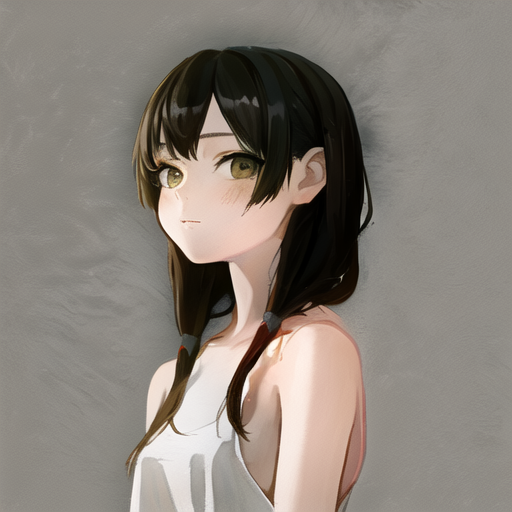

In [84]:
outputpos.images[0]

In [95]:
init_image = output[0].images[0]

prompt = "anime girl by tabi, solo, 1girl, fantasy, at night, cowboy shot, outdoors, 4K wallpaper"
negative_prompt = "worst quality, low quality, medium quality, deleted, lowres, comic, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, jpeg artifacts, signature, watermark, username, blurry"

outputpos = pipepos(prompt=prompt, negative_prompt=negative_prompt,
                    image=init_image, strength=0.7, guidance_scale=7.5,
                    add_predicted_noise=True, wavelet_level=4, match_high_frequency=False)

  0%|          | 0/35 [00:00<?, ?it/s]

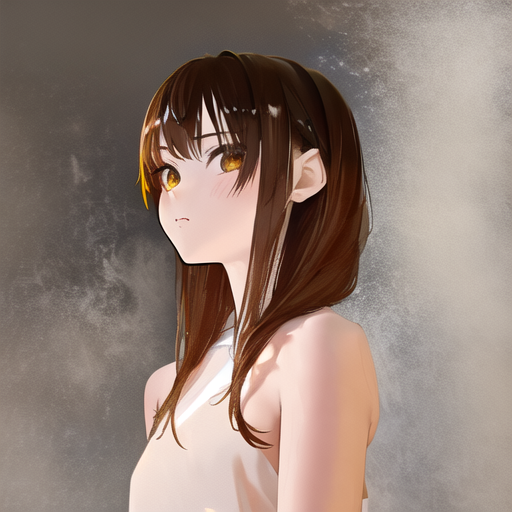

In [96]:
outputpos.images[0]